In [ ]:
# Kaggle API 라이브러리 인스톨
! pip install -q kaggle

In [ ]:
# Kaggle API 호출을 위한 API Key 업로드
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          11958        353  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           3861        101  1.0              
harshsingh2209/tesla-stock-pricing-20172022                    TESLA stock pricing (2017-2022)                      28KB  2022-09-18 14:56:29            825         29  1.0              
thedevastator/airplane-crashes-

In [ ]:
# 학습 데이터 다운로드 및 압축풀기

! kaggle datasets download -d phylake1337/fire-dataset
! unzip fire-dataset.zip

 92% 358M/387M [00:01<00:00, 204MB/s]
100% 387M/387M [00:01<00:00, 206MB/s]
Archive:  fire-dataset.zip
  inflating: fire_dataset/fire_images/fire.1.png  
  inflating: fire_dataset/fire_images/fire.10.png  
  inflating: fire_dataset/fire_images/fire.100.png  
  inflating: fire_dataset/fire_images/fire.101.png  
  inflating: fire_dataset/fire_images/fire.102.png  
  inflating: fire_dataset/fire_images/fire.103.png  
  inflating: fire_dataset/fire_images/fire.104.png  
  inflating: fire_dataset/fire_images/fire.105.png  
  inflating: fire_dataset/fire_images/fire.106.png  
  inflating: fire_dataset/fire_images/fire.107.png  
  inflating: fire_dataset/fire_images/fire.108.png  
  inflating: fire_dataset/fire_images/fire.109.png  
  inflating: fire_dataset/fire_images/fire.11.png  
  inflating: fire_dataset/fire_images/fire.110.png  
  inflating: fire_dataset/fire_images/fire.111.png  
  inflating: fire_dataset/fire_images/fire.112.png  
  inflating: fire_dataset/fire_images/fire.113.png  


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')

In [ ]:
# 데이터 프레임 만들기 (파일 위치, 레이블)

import pandas as pd
import os

# 빈 데이터프레임 생성
df = pd.DataFrame(columns=['path','label'])

# fire 이미지와 레이블 'fire'
for dirname, _, filenames in os.walk('/content/fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

# non-fire 이미지와 레이블 'non_file'
for dirname, _, filenames in os.walk('/content/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

# 학습을 위한 데이터 섞기
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

path label
0  /content/fire_dataset/fire_images/fire.398.png  fire
1  /content/fire_dataset/fire_images/fire.387.png  fire
2  /content/fire_dataset/fire_images/fire.730.png  fire
3  /content/fire_dataset/fire_images/fire.447.png  fire
4  /content/fire_dataset/fire_images/fire.650.png  fire
5  /content/fire_dataset/fire_images/fire.442.png  fire
6  /content/fire_dataset/fire_images/fire.143.png  fire
7  /content/fire_dataset/fire_images/fire.754.png  fire
8  /content/fire_dataset/fire_images/fire.342.png  fire
9  /content/fire_dataset/fire_images/fire.325.png  fire

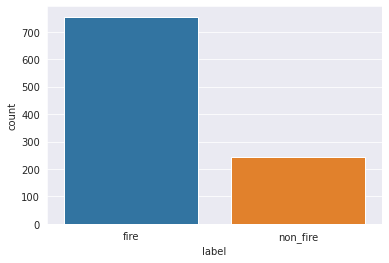

In [ ]:
# 데이터 비율 확인
import seaborn as sns
sns.countplot(data=df, x='label', order=['fire','non_fire'])

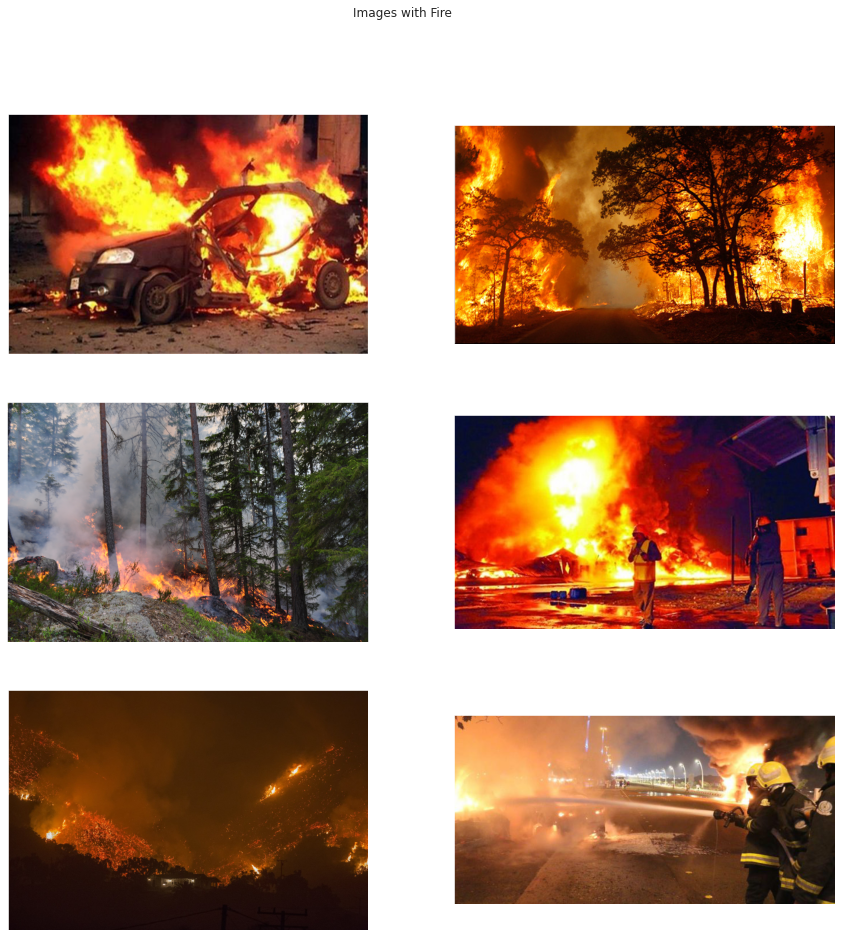

In [ ]:
# fire 이미지 샘플 확인
import matplotlib.pyplot as plt

label = 'fire'
data = df[df['label'] == label]
#sns.set_style('dark')

pics = 6 # 샘플 갯수
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

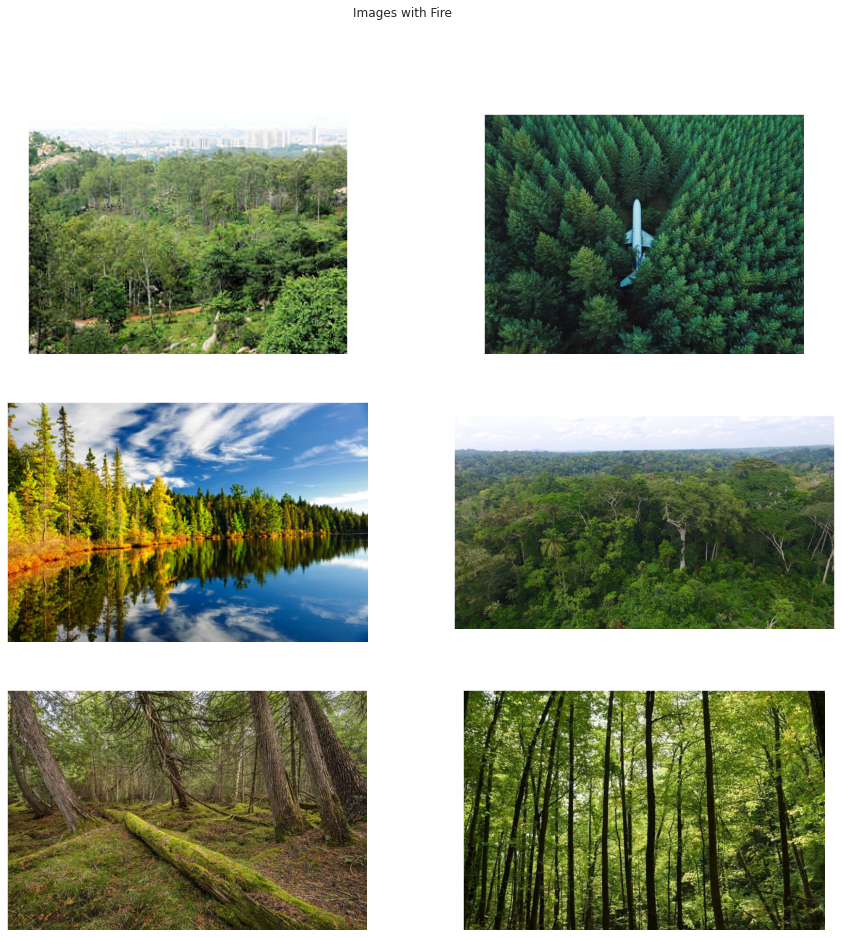

In [ ]:
# non-fire 이미지 샘플 확인

label = 'non_fire'
data = df[df['label'] == label]
#sns.set_style('dark')

pics = 6 # 샘플 갯수
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

# 이미지 크기 조정 필요

In [ ]:
# 데이터 증강 (Augmentation)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)


In [ ]:
# 학습 집합과 검증 집합 생성
# ImageDataGenerator가 자동으로 레이블을 인코딩
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
# ImageDataGenerator가 생성한 레이블 확인

class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key

print(class_indices)

{0: 'fire', 1: 'non_fire'}


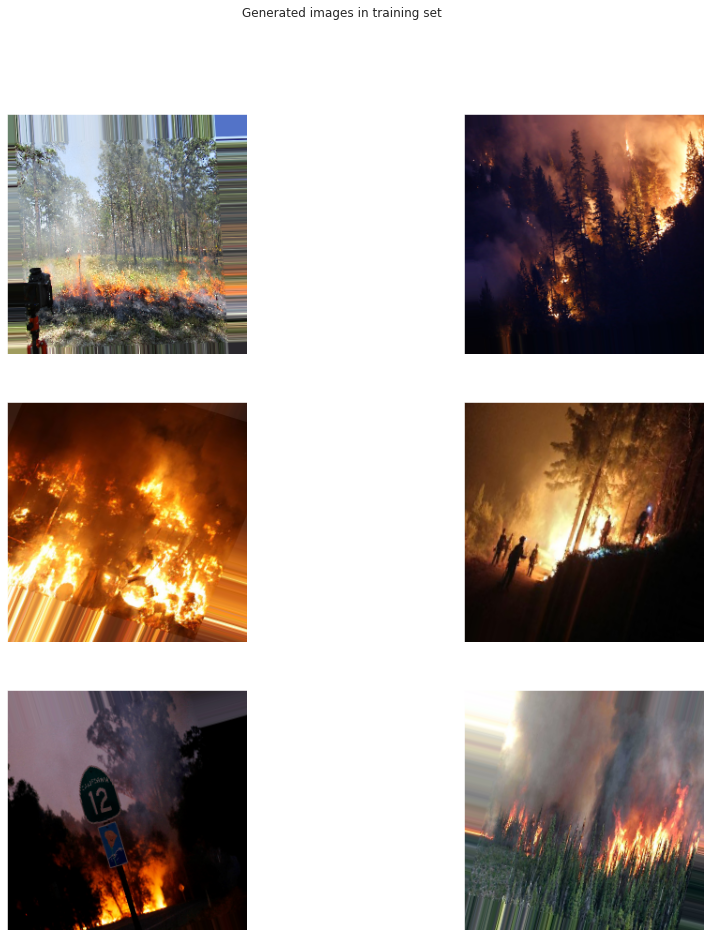

In [ ]:
# ImageDataGenerator가 생성한 이미지 확인

pics = 6 # 샘플 갯수
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [ ]:
# 모델 정의

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))  #왜 3일까요?
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid')) #왜 sigmoid일까요?

# 앞 부분에는 노이즈가 많으므로 적은 필터를 사용하고 깊은 층으로 갈수록 더 많은 특징을 추출하기 위해 필터 수를 늘입니다.

In [ ]:
# 모델 구조 요약

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

In [ ]:
# 모델 컴파일

from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()]) # 왜 binary_crossentrophy 일까요?  # 왜 Recall이 중요할까요?

In [ ]:
# 조기종료 적용

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
class_weight={0:0.3, 1:1.}

In [ ]:
# 학습
model.fit(x=train_gen,batch_size=32,epochs=5,validation_data=val_gen,callbacks=[early_stoppping], class_weight=class_weight)

Epoch 1/5
25/25 [==============================] - 58s 2s/step - loss: 0.3504 - accuracy: 0.8325 - recall: 0.6340 - auc: 0.8839 - val_loss: 0.2533 - val_accuracy: 0.8995 - val_recall: 0.6000 - val_auc: 0.9798
Epoch 2/5
25/25 [==============================] - 41s 2s/step - loss: 0.1316 - accuracy: 0.9500 - recall: 0.8557 - auc: 0.9843 - val_loss: 0.1314 - val_accuracy: 0.9598 - val_recall: 0.9000 - val_auc: 0.9832
Epoch 3/5
25/25 [==============================] - 39s 2s/step - loss: 0.1149 - accuracy: 0.9488 - recall: 0.8814 - auc: 0.9893 - val_loss: 0.1487 - val_accuracy: 0.9447 - val_recall: 0.7800 - val_auc: 0.9897
Epoch 4/5
25/25 [==============================] - 38s 2s/step - loss: 0.1168 - accuracy: 0.9550 - recall: 0.8969 - auc: 0.9847 - val_loss: 0.1156 - val_accuracy: 0.9598 - val_recall: 0.9200 - val_auc: 0.9901
Epoch 5/5
25/25 [==============================] - 38s 2s/step - loss: 0.0886 - accuracy: 0.9663 - recall: 0.9175 - auc: 0.9937 - val_loss: 0.1099 - val_accuracy: 0

In [ ]:
# 학습 그래프 보기

history= model.history.history
px.line(history,title = "Metrics Plot")

In [ ]:
# 모델 평가
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

# 잘한 것일까요?

7/7 [==============================] - 8s 973ms/step - loss: 0.1005 - accuracy: 0.9598 - recall: 0.9000 - auc: 0.9923
loss: 0.10
accuracy: 0.96
recall: 0.90
auc: 0.99


직접 모델을 개발하는 대신 누군가가 만들어 놓은 사전학습 모델을 사용해 봅시다.

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout


# 사전학습 모델 다운로드 및 산불화재탐지 모델 정의
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
# 모델 컴파일

model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

In [ ]:
# 학습
history2 = model2.fit(x = train_gen,batch_size=32,epochs=5,callbacks = [early_stoppping],validation_data = val_gen, class_weight=class_weight)


Epoch 1/5
25/25 [==============================] - 45s 2s/step - loss: 0.9252 - accuracy: 0.8875 - recall_1: 0.7938 - auc_1: 0.9001 - val_loss: 0.4408 - val_accuracy: 0.9296 - val_recall_1: 0.7600 - val_auc_1: 0.9438
Epoch 2/5
25/25 [==============================] - 40s 2s/step - loss: 0.3076 - accuracy: 0.9450 - recall_1: 0.8608 - auc_1: 0.9584 - val_loss: 0.1030 - val_accuracy: 0.9849 - val_recall_1: 0.9400 - val_auc_1: 0.9793
Epoch 3/5
25/25 [==============================] - 39s 2s/step - loss: 0.2023 - accuracy: 0.9700 - recall_1: 0.9536 - auc_1: 0.9758 - val_loss: 0.0966 - val_accuracy: 0.9648 - val_recall_1: 1.0000 - val_auc_1: 0.9986
Epoch 4/5
25/25 [==============================] - 39s 2s/step - loss: 0.1248 - accuracy: 0.9700 - recall_1: 0.9433 - auc_1: 0.9883 - val_loss: 0.1910 - val_accuracy: 0.9598 - val_recall_1: 0.8600 - val_auc_1: 0.9691
Epoch 5/5
25/25 [==============================] - 39s 2s/step - loss: 0.1098 - accuracy: 0.9800 - recall_1: 0.9485 - auc_1: 0.9884 

In [ ]:
# 학습 그래프 보기

history= model2.history.history
px.line(history,title='Metrics Plot')

In [ ]:
# 모델 평가

eval_list = model2.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 8s 1s/step - loss: 0.0858 - accuracy: 0.9648 - recall_1: 0.9800 - auc_1: 0.9952
loss: 0.09
accuracy: 0.96
recall_1: 0.98
auc_1: 1.00


학습된 모델로 인터넷에서 다운로드 받은 사진을 탐지해 봅시다.

In [ ]:
# 이미지 다운로드
#!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg
#!curl https://transcode-v2.app.engoo.com/image/fetch/f_auto,c_limit,w_1280,h_800,dpr_2/https://assets.app.engoo.com/images/6b7V4hOYczy7ODsXQtkVAg.jpeg --output predict.jpg
!curl https://img.seoul.co.kr/img/upload/2020/07/01/SSI_20200701210037.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  464k  100  464k    0     0   502k      0 --:--:-- --:--:-- --:--:--  502k


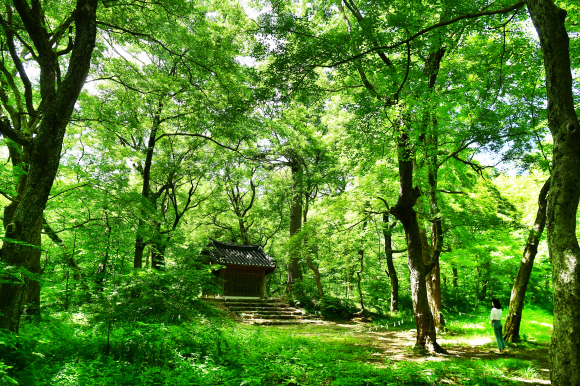

In [ ]:
# 다운로드 이미지 확인
img = image.load_img('predict.jpg')
img

In [ ]:
# 이미지를 모델에 입력형태로 변환

img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


In [ ]:
# 예측 및 결과 확인
prediction = int(tf.round(model.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

The predicted value is:  1 and the predicted label is: non_fire
